In [73]:
import numpy as np
import pandas as pd
import datetime as dt
from sklearn.model_selection import train_test_split
import sklearn
import xgboost as xgb
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [74]:
df_customers = pd.read_csv("olist_customers_dataset.csv")
df_geolocation = pd.read_csv("olist_geolocation_dataset.csv")
df_orders = pd.read_csv("olist_orders_dataset.csv")
df_order_items = pd.read_csv("olist_order_items_dataset.csv")
df_order_payments = pd.read_csv("olist_order_payments_dataset.csv")
df_order_reviews = pd.read_csv("olist_order_reviews_dataset.csv")
df_products = pd.read_csv("olist_products_dataset.csv")
df_sellers = pd.read_csv("olist_sellers_dataset.csv")
df_translations = pd.read_csv("product_category_name_translation.csv")

In [75]:
df_merge = pd.merge(df_orders, df_order_payments, on='order_id')
df_merge = pd.merge(df_merge, df_customers, on='customer_id')
df_merge = pd.merge(df_merge, df_order_items, on='order_id')
df_merge = pd.merge(df_merge, df_sellers, on='seller_id')
df_merge = pd.merge(df_merge, df_order_reviews, on='order_id')
df_merge = pd.merge(df_merge, df_products, on='product_id')

In [76]:
df_translations.columns = ['product_category_name', 'product_category_name_english']
df_merge = pd.merge(df_merge, df_translations, on='product_category_name')

df_merge.info()
df_merge.shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115609 entries, 0 to 115608
Data columns (total 40 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       115609 non-null  object 
 1   customer_id                    115609 non-null  object 
 2   order_status                   115609 non-null  object 
 3   order_purchase_timestamp       115609 non-null  object 
 4   order_approved_at              115595 non-null  object 
 5   order_delivered_carrier_date   114414 non-null  object 
 6   order_delivered_customer_date  113209 non-null  object 
 7   order_estimated_delivery_date  115609 non-null  object 
 8   payment_sequential             115609 non-null  int64  
 9   payment_type                   115609 non-null  object 
 10  payment_installments           115609 non-null  int64  
 11  payment_value                  115609 non-null  float64
 12  customer_unique_id            

(115609, 40)

In [77]:
# Deleting Duplicated Rows
df_merge = df_merge.drop_duplicates(subset={'order_id',
                                            'customer_id',
                                            'order_purchase_timestamp',
                                            'order_delivered_customer_date'}, keep='first')
df_merge.shape

(96516, 40)

In [78]:
df_merge.isnull().sum()

order_id                             0
customer_id                          0
order_status                         0
order_purchase_timestamp             0
order_approved_at                   13
order_delivered_carrier_date       959
order_delivered_customer_date     2030
order_estimated_delivery_date        0
payment_sequential                   0
payment_type                         0
payment_installments                 0
payment_value                        0
customer_unique_id                   0
customer_zip_code_prefix             0
customer_city                        0
customer_state                       0
order_item_id                        0
product_id                           0
seller_id                            0
shipping_limit_date                  0
price                                0
freight_value                        0
seller_zip_code_prefix               0
seller_city                          0
seller_state                         0
review_id                

In [79]:
df_merge.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,...,review_answer_timestamp,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1,credit_card,...,2017-10-12 03:43:48,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28 00:00:00,1,credit_card,...,2017-08-20 15:16:36,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15 00:00:00,1,credit_card,...,2017-08-08 23:26:23,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares
5,bfc39df4f36c3693ff3b63fcbea9e90a,53904ddbea91e1e92b2b3f1d09a7af86,delivered,2017-10-23 23:26:46,2017-10-25 02:14:11,2017-10-27 16:48:46,2017-11-07 18:04:59,2017-11-13 00:00:00,1,boleto,...,2017-11-10 19:52:38,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares
6,5f49f31e537f8f1a496454b48edbe34d,a7260a6ccba78544ccfaf43f920b7240,delivered,2017-08-24 11:31:28,2017-08-24 11:45:25,2017-08-25 14:17:55,2017-08-28 20:12:20,2017-09-14 00:00:00,1,credit_card,...,2017-08-30 02:26:02,utilidades_domesticas,59.0,189.0,3.0,775.0,16.0,16.0,13.0,housewares


In [80]:
df_merge.drop(['review_comment_title', 'review_comment_message'], axis = 1, inplace = True)

In [81]:
df_merge.dropna(axis = 0, inplace = True)

In [82]:
df_merge.shape

(94471, 38)

In [83]:
df_merge.isnull().sum()

order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     0
order_delivered_customer_date    0
order_estimated_delivery_date    0
payment_sequential               0
payment_type                     0
payment_installments             0
payment_value                    0
customer_unique_id               0
customer_zip_code_prefix         0
customer_city                    0
customer_state                   0
order_item_id                    0
product_id                       0
seller_id                        0
shipping_limit_date              0
price                            0
freight_value                    0
seller_zip_code_prefix           0
seller_city                      0
seller_state                     0
review_id                        0
review_score                     0
review_creation_date             0
review_answer_timest

In [84]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94471 entries, 0 to 115607
Data columns (total 38 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_id                       94471 non-null  object 
 1   customer_id                    94471 non-null  object 
 2   order_status                   94471 non-null  object 
 3   order_purchase_timestamp       94471 non-null  object 
 4   order_approved_at              94471 non-null  object 
 5   order_delivered_carrier_date   94471 non-null  object 
 6   order_delivered_customer_date  94471 non-null  object 
 7   order_estimated_delivery_date  94471 non-null  object 
 8   payment_sequential             94471 non-null  int64  
 9   payment_type                   94471 non-null  object 
 10  payment_installments           94471 non-null  int64  
 11  payment_value                  94471 non-null  float64
 12  customer_unique_id             94471 non-null

In [85]:
df_merge['order_purchase_timestamp'] = pd.to_datetime(df_merge['order_purchase_timestamp'],
                                            infer_datetime_format=True,
                                            errors='ignore')

df_merge["order_purchase_timestamp"].head()

0   2017-10-02 10:56:33
3   2017-08-15 18:29:31
4   2017-08-02 18:24:47
5   2017-10-23 23:26:46
6   2017-08-24 11:31:28
Name: order_purchase_timestamp, dtype: datetime64[ns]

In [86]:
data = df_merge.copy()

In [87]:
data['product_category_name'].nunique()

71

In [88]:
data.isnull().sum()

order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     0
order_delivered_customer_date    0
order_estimated_delivery_date    0
payment_sequential               0
payment_type                     0
payment_installments             0
payment_value                    0
customer_unique_id               0
customer_zip_code_prefix         0
customer_city                    0
customer_state                   0
order_item_id                    0
product_id                       0
seller_id                        0
shipping_limit_date              0
price                            0
freight_value                    0
seller_zip_code_prefix           0
seller_city                      0
seller_state                     0
review_id                        0
review_score                     0
review_creation_date             0
review_answer_timest

In [89]:
data.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,...,review_answer_timestamp,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1,credit_card,...,2017-10-12 03:43:48,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28 00:00:00,1,credit_card,...,2017-08-20 15:16:36,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15 00:00:00,1,credit_card,...,2017-08-08 23:26:23,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares
5,bfc39df4f36c3693ff3b63fcbea9e90a,53904ddbea91e1e92b2b3f1d09a7af86,delivered,2017-10-23 23:26:46,2017-10-25 02:14:11,2017-10-27 16:48:46,2017-11-07 18:04:59,2017-11-13 00:00:00,1,boleto,...,2017-11-10 19:52:38,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares
6,5f49f31e537f8f1a496454b48edbe34d,a7260a6ccba78544ccfaf43f920b7240,delivered,2017-08-24 11:31:28,2017-08-24 11:45:25,2017-08-25 14:17:55,2017-08-28 20:12:20,2017-09-14 00:00:00,1,credit_card,...,2017-08-30 02:26:02,utilidades_domesticas,59.0,189.0,3.0,775.0,16.0,16.0,13.0,housewares


In [90]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94471 entries, 0 to 115607
Data columns (total 38 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       94471 non-null  object        
 1   customer_id                    94471 non-null  object        
 2   order_status                   94471 non-null  object        
 3   order_purchase_timestamp       94471 non-null  datetime64[ns]
 4   order_approved_at              94471 non-null  object        
 5   order_delivered_carrier_date   94471 non-null  object        
 6   order_delivered_customer_date  94471 non-null  object        
 7   order_estimated_delivery_date  94471 non-null  object        
 8   payment_sequential             94471 non-null  int64         
 9   payment_type                   94471 non-null  object        
 10  payment_installments           94471 non-null  int64         
 11  payment_value 

In [91]:
df_recency = data.groupby(by = 'customer_unique_id', as_index = False)['order_purchase_timestamp'].max()

#Renaming the column:
df_recency.rename(columns = {"order_purchase_timestamp": "LastPurchaseDate"}, inplace = True)

#Removing time and extracting only date from the datetime field:
df_recency["LastPurchaseDate"] = df_recency["LastPurchaseDate"].dt.date

#Using the last order in the entire dataset as a reference point to calculate recency:
recent_date = data['order_purchase_timestamp'].dt.date.max()
df_recency['Recency'] = df_recency['LastPurchaseDate'].apply(lambda x: (recent_date - x).days)

df_recency.head()
#df_recency['is_churn'] = df_recency['Recency'].apply(lambda x: True if x >= 365 else False)
#df_recency


,customer_unique_id,LastPurchaseDate,Recency
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10,111
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07,114
2,0000f46a3911fa3c0805444483337064,2017-03-10,537
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12,321
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14,288


In [92]:
#df_recency['is_churn'] = df_recency['Recency'].apply(lambda x: True if x >= 365 else False)
#df_recency

In [93]:
#Grouping the data by Customer Unique ID to calculate the number of unique Order IDs for every customer.
frequency_df = data.groupby(["customer_unique_id"]).agg({"order_id": "nunique"}).reset_index()

#Renaming the column:
frequency_df.rename(columns = {"order_id": "Frequency"}, inplace = True)

frequency_df.head()

,customer_unique_id,Frequency
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1


In [94]:
#Grouping the data by Customer Unique ID to calulcate the total spending of every customer.
monetary_df = data.groupby('customer_unique_id', as_index = False)['payment_value'].sum()

#Renaming the column:
monetary_df.rename(columns = {"payment_value": "Monetary"}, inplace = True)

monetary_df.head()

,customer_unique_id,Monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19
2,0000f46a3911fa3c0805444483337064,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,43.62
4,0004aac84e0df4da2b147fca70cf8255,196.89


In [95]:
#Cluster 0 : This cluster can be interpreted as the (Relatively New Customers/Low spenders) as their spending is the smallest among all clusters but are the most recent customers. It is the biggest cluster and therefore present the biggest opportunity for the company to increase their customer base. Specialized marketing towards these customers could help increase the company's relevance among them and thereby convert them into loyal, higher spenders.

#Cluster 1 : The customers in this cluster represent failed conversion of Cluster 0 (Relatively New Customers/Low spenders) customers into Cluster 2 (Loyal/Slightly Higher Spenders). This cluster represents the company's customer (Churn).

#Cluster 2 : This cluster can be interpreted as the (Loyal/Slightly Higher Spenders). Customers in this cluster have the highest order frequency and slightly higher spending compared to the new customers. Marketing towards these customers should focus on loyalty programs thereby improving retention.

#Cluster 3 : This cluster can be interpreted as the (Big Spenders) as they spend the most (excluding Cluster 4 (Anomaly)) and are the second most frequent buyers after Cluster 2 (Loyal/Slightly Higher Spenders). Marketing towards these customers should focus on product recommendations as they seem keen on spending high amounts of money thereby driving higher profits.

#Cluster 4 : There is only a single customer in this cluster and they have spent an extremely high amount of money (R$109,312.64) on their order. This cluster can be interpreted as the (Anomaly).

In [96]:
rfm = df_recency.merge(frequency_df, on = 'customer_unique_id') \
                .merge(monetary_df, on = 'customer_unique_id') 
                

#Dropping the 'Last Purchase Date' column:
rfm.drop('LastPurchaseDate', axis = 1, inplace = True)



In [138]:
rfm.head()

,customer_unique_id,Recency,Frequency,Monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,111,1,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,27.19
2,0000f46a3911fa3c0805444483337064,537,1,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,43.62
4,0004aac84e0df4da2b147fca70cf8255,288,1,196.89


In [139]:
rfm1 = rfm.copy()

In [98]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_rfm = scaler.fit_transform(rfm.drop('customer_unique_id', axis = 1))

scaled_rfm_df = pd.DataFrame(scaled_rfm, columns = rfm.columns[1:])

In [99]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

n_clusters = [3, 4, 5, 6, 7, 8]
silhouette_scores = []

for K in n_clusters:
    initialized_clusters = KMeans(n_clusters = K, random_state = 10)
    data_fitted_clusters = initialized_clusters.fit_predict(scaled_rfm_df)
    silhoette_score = silhouette_score(scaled_rfm_df, data_fitted_clusters, random_state = 10)
    silhouette_scores.append(silhoette_score)

In [100]:
final_model = KMeans(n_clusters = 5, random_state = 10)
final_model.fit(scaled_rfm_df)

KMeans(n_clusters=5, random_state=10)

In [105]:
data_output = rfm.copy()
data_output['Segment'] = final_model.labels_
data_output.sample(5)

,customer_unique_id,Recency,Frequency,Monetary,Segment
18208,32d14f27b8fe070aa29648ce65b384e2,191,1,190.43,4
43660,7a058fb903db07aea7cad4ed26301dd1,184,1,34.00,4
65134,b6172f1929f3af288c2f3693f2d05dd9,427,1,1003.42,2
43344,791a3bdf48dd1fed7c084358b77c277c,192,1,912.69,2
78901,dc79b8df4fa615a9753973a511849ab9,184,1,165.30,4


In [106]:
data_output.head()

,customer_unique_id,Recency,Frequency,Monetary,Segment
0,0000366f3b9a7992bf8c76cfdf3221e2,111,1,141.90,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,27.19,0
2,0000f46a3911fa3c0805444483337064,537,1,86.22,1
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,43.62,4
4,0004aac84e0df4da2b147fca70cf8255,288,1,196.89,4


In [107]:
data1 = data.merge(data_output, on ='customer_unique_id')

In [108]:
data1['Segment'].replace({0:'New Customer', 1:'Churn customers', 2:'Need Attention',  3: 'Potential Loyal Customers', 4: 'Loyal Customers'},inplace=True)

In [109]:
data1.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,...,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,Recency,Frequency,Monetary,Segment
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1,credit_card,...,4.0,500.0,19.0,8.0,13.0,housewares,331,2,62.23,Potential Loyal Customers
1,69923a4e07ce446644394df37a710286,31f31efcb333fcbad2b1371c8cf0fa84,delivered,2017-09-04 11:26:38,2017-09-04 11:43:25,2017-09-04 21:22:15,2017-09-05 19:20:20,2017-09-15 00:00:00,1,credit_card,...,1.0,350.0,19.0,14.0,12.0,baby,331,2,62.23,Potential Loyal Customers
2,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28 00:00:00,1,credit_card,...,4.0,500.0,19.0,8.0,13.0,housewares,379,1,37.77,Churn customers
3,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15 00:00:00,1,credit_card,...,4.0,500.0,19.0,8.0,13.0,housewares,392,1,37.77,Churn customers
4,bfc39df4f36c3693ff3b63fcbea9e90a,53904ddbea91e1e92b2b3f1d09a7af86,delivered,2017-10-23 23:26:46,2017-10-25 02:14:11,2017-10-27 16:48:46,2017-11-07 18:04:59,2017-11-13 00:00:00,1,boleto,...,4.0,500.0,19.0,8.0,13.0,housewares,310,1,44.09,Loyal Customers


In [110]:
total_order = data1[['order_id', 'order_item_id']].groupby('order_id').max().reset_index()
total_order.rename(columns={'order_item_id':'total_items'}, inplace=True)
total_order.head()

,order_id,total_items
0,00010242fe8c5a6d1ba2dd792cb16214,1
1,00018f77f2f0320c557190d7a144bdd3,1
2,000229ec398224ef6ca0657da4fc703e,1
3,00024acbcdf0a6daa1e931b038114c75,1
4,00042b26cf59d7ce69dfabb4e55b4fd9,1


In [111]:
data2= data1.merge(total_order, on = 'order_id')
data2.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,...,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,Recency,Frequency,Monetary,Segment,total_items
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1,credit_card,...,500.0,19.0,8.0,13.0,housewares,331,2,62.23,Potential Loyal Customers,1
1,69923a4e07ce446644394df37a710286,31f31efcb333fcbad2b1371c8cf0fa84,delivered,2017-09-04 11:26:38,2017-09-04 11:43:25,2017-09-04 21:22:15,2017-09-05 19:20:20,2017-09-15 00:00:00,1,credit_card,...,350.0,19.0,14.0,12.0,baby,331,2,62.23,Potential Loyal Customers,1
2,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28 00:00:00,1,credit_card,...,500.0,19.0,8.0,13.0,housewares,379,1,37.77,Churn customers,1
3,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15 00:00:00,1,credit_card,...,500.0,19.0,8.0,13.0,housewares,392,1,37.77,Churn customers,1
4,bfc39df4f36c3693ff3b63fcbea9e90a,53904ddbea91e1e92b2b3f1d09a7af86,delivered,2017-10-23 23:26:46,2017-10-25 02:14:11,2017-10-27 16:48:46,2017-11-07 18:04:59,2017-11-13 00:00:00,1,boleto,...,500.0,19.0,8.0,13.0,housewares,310,1,44.09,Loyal Customers,1


In [112]:
# Total Price
data2['total_price'] = data2['total_items'] * data2['price']

# Total Freight Value
data2['total_freight_value'] = data2['total_items'] * data2['freight_value']

# Total Order Value
data2['total_order_value'] = data2['total_price'] + data2['total_freight_value']

data2.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,...,product_width_cm,product_category_name_english,Recency,Frequency,Monetary,Segment,total_items,total_price,total_freight_value,total_order_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1,credit_card,...,13.0,housewares,331,2,62.23,Potential Loyal Customers,1,29.99,8.72,38.71
1,69923a4e07ce446644394df37a710286,31f31efcb333fcbad2b1371c8cf0fa84,delivered,2017-09-04 11:26:38,2017-09-04 11:43:25,2017-09-04 21:22:15,2017-09-05 19:20:20,2017-09-15 00:00:00,1,credit_card,...,12.0,baby,331,2,62.23,Potential Loyal Customers,1,35.39,8.72,44.11
2,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28 00:00:00,1,credit_card,...,13.0,housewares,379,1,37.77,Churn customers,1,29.99,7.78,37.77
3,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15 00:00:00,1,credit_card,...,13.0,housewares,392,1,37.77,Churn customers,1,29.99,7.78,37.77
4,bfc39df4f36c3693ff3b63fcbea9e90a,53904ddbea91e1e92b2b3f1d09a7af86,delivered,2017-10-23 23:26:46,2017-10-25 02:14:11,2017-10-27 16:48:46,2017-11-07 18:04:59,2017-11-13 00:00:00,1,boleto,...,13.0,housewares,310,1,44.09,Loyal Customers,1,29.99,14.10,44.09


In [113]:
avg_payment_installments = data2.groupby('customer_unique_id')['payment_installments'].mean()\
    .reset_index().rename({'payment_installments':'avg_payment_installments'},axis = 1)
avg_payment_installments.head()

,customer_unique_id,avg_payment_installments
0,0000366f3b9a7992bf8c76cfdf3221e2,8.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1.0
2,0000f46a3911fa3c0805444483337064,8.0
3,0000f6ccb0745a6a4b88665a16c9f078,4.0
4,0004aac84e0df4da2b147fca70cf8255,6.0


In [114]:
data3 = data2.merge(avg_payment_installments, on = 'customer_unique_id')
data3.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,...,product_category_name_english,Recency,Frequency,Monetary,Segment,total_items,total_price,total_freight_value,total_order_value,avg_payment_installments
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1,credit_card,...,housewares,331,2,62.23,Potential Loyal Customers,1,29.99,8.72,38.71,1.0
1,69923a4e07ce446644394df37a710286,31f31efcb333fcbad2b1371c8cf0fa84,delivered,2017-09-04 11:26:38,2017-09-04 11:43:25,2017-09-04 21:22:15,2017-09-05 19:20:20,2017-09-15 00:00:00,1,credit_card,...,baby,331,2,62.23,Potential Loyal Customers,1,35.39,8.72,44.11,1.0
2,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28 00:00:00,1,credit_card,...,housewares,379,1,37.77,Churn customers,1,29.99,7.78,37.77,3.0
3,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15 00:00:00,1,credit_card,...,housewares,392,1,37.77,Churn customers,1,29.99,7.78,37.77,1.0
4,bfc39df4f36c3693ff3b63fcbea9e90a,53904ddbea91e1e92b2b3f1d09a7af86,delivered,2017-10-23 23:26:46,2017-10-25 02:14:11,2017-10-27 16:48:46,2017-11-07 18:04:59,2017-11-13 00:00:00,1,boleto,...,housewares,310,1,44.09,Loyal Customers,1,29.99,14.10,44.09,1.0


In [115]:
data3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94471 entries, 0 to 94470
Data columns (total 47 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       94471 non-null  object        
 1   customer_id                    94471 non-null  object        
 2   order_status                   94471 non-null  object        
 3   order_purchase_timestamp       94471 non-null  datetime64[ns]
 4   order_approved_at              94471 non-null  object        
 5   order_delivered_carrier_date   94471 non-null  object        
 6   order_delivered_customer_date  94471 non-null  object        
 7   order_estimated_delivery_date  94471 non-null  object        
 8   payment_sequential             94471 non-null  int64         
 9   payment_type                   94471 non-null  object        
 10  payment_installments           94471 non-null  int64         
 11  payment_value  

In [116]:
data3 = data3.drop(["order_id", "customer_id", "order_status", "order_purchase_timestamp", "order_approved_at", 
                   "order_delivered_carrier_date", "order_delivered_customer_date", "order_estimated_delivery_date",
                   "payment_sequential", "payment_installments", "payment_value", "customer_unique_id",
                    "customer_zip_code_prefix", "customer_city", "order_item_id", "seller_id", "shipping_limit_date",
                   "price", "freight_value", "seller_zip_code_prefix", "seller_city", "seller_state", "review_id", 
                   "review_creation_date", "review_answer_timestamp", "product_name_lenght", "product_description_lenght",
                   "product_photos_qty", "product_weight_g", "product_length_cm", "product_height_cm", 
                   "product_width_cm", "product_width_cm", "product_category_name_english"], axis = 1)

In [117]:
data3 = data3.drop([ "Frequency", "Monetary"], axis = 1)
   

In [137]:
data3.to_excel("OList_marketing.xlsx")

In [118]:
data3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94471 entries, 0 to 94470
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   payment_type              94471 non-null  object 
 1   customer_state            94471 non-null  object 
 2   product_id                94471 non-null  object 
 3   review_score              94471 non-null  int64  
 4   product_category_name     94471 non-null  object 
 5   Recency                   94471 non-null  int64  
 6   Segment                   94471 non-null  object 
 7   total_items               94471 non-null  int64  
 8   total_price               94471 non-null  float64
 9   total_freight_value       94471 non-null  float64
 10  total_order_value         94471 non-null  float64
 11  avg_payment_installments  94471 non-null  float64
dtypes: float64(4), int64(3), object(5)
memory usage: 9.4+ MB


In [125]:
objList = data3.select_dtypes(include = "object").columns 
print (objList)

Index([], dtype='object')


In [126]:
from sklearn.preprocessing import LabelEncoder #encoder package of sklearn
le = LabelEncoder() #le variable has been assigned a labelencoder function

for Shiv in objList:
    data3[Shiv] = le.fit_transform(data3[Shiv].astype(str))

print (data3.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94471 entries, 0 to 94470
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   payment_type              94471 non-null  int32  
 1   customer_state            94471 non-null  int32  
 2   product_id                94471 non-null  int32  
 3   review_score              94471 non-null  int64  
 4   product_category_name     94471 non-null  int32  
 5   Recency                   94471 non-null  int64  
 6   Segment                   94471 non-null  int32  
 7   total_items               94471 non-null  int64  
 8   total_price               94471 non-null  float64
 9   total_freight_value       94471 non-null  float64
 10  total_order_value         94471 non-null  float64
 11  avg_payment_installments  94471 non-null  float64
dtypes: float64(4), int32(5), int64(3)
memory usage: 7.6 MB
None


In [127]:
trd = data3.drop('Segment',axis=1) #trd is training data
trl = data3['Segment'] #trl is training label

In [128]:
# Scaling of data:

from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
scaler = MinMaxScaler(feature_range = (0,1))
scaler.fit(trd)
X_offer = scaler.transform(trd)

In [129]:
X_train, X_test, y_train, y_test = train_test_split(trd, trl, test_size=0.2, random_state=0,stratify=trl)

In [130]:
#building the model & printing the score
xgb_model = xgb.XGBClassifier(max_depth=5, learning_rate=0.08, objective= 'binary:logistic',n_jobs=-1).fit(X_train, y_train)
print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(xgb_model.score(X_test[X_train.columns], y_test)))

Accuracy of XGB classifier on training set: 0.95
Accuracy of XGB classifier on test set: 0.95


In [136]:
from joblib import dump
dump(xgb_model,'Olist_marketing.joblib')

['Olist_marketing.joblib']

In [131]:
y_pred = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      4056
           1       0.95      1.00      0.97      6516
           2       0.94      0.84      0.89       474
           3       0.94      1.00      0.97      6718
           4       1.00      0.21      0.35      1131

    accuracy                           0.95     18895
   macro avg       0.96      0.81      0.83     18895
weighted avg       0.95      0.95      0.93     18895



<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

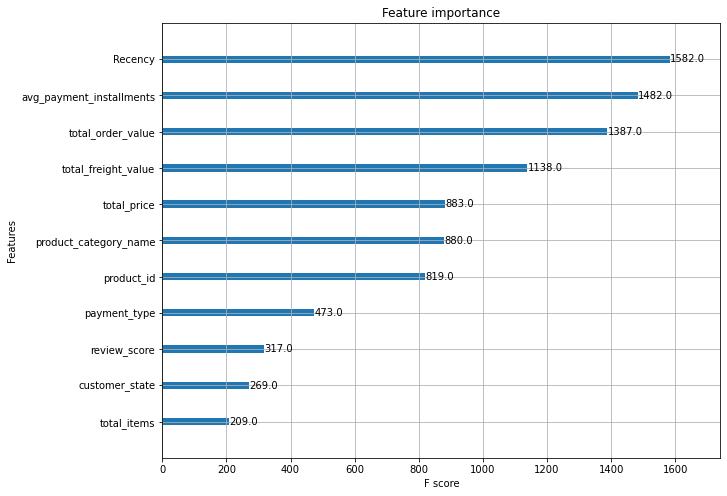

In [132]:
from xgboost import plot_importance
fig, ax = plt.subplots(figsize=(10,8))
plot_importance(xgb_model, ax=ax)

Product Recommendation

In [141]:
from sklearn.decomposition import TruncatedSVD

In [142]:
data.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,...,review_answer_timestamp,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1,credit_card,...,2017-10-12 03:43:48,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28 00:00:00,1,credit_card,...,2017-08-20 15:16:36,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15 00:00:00,1,credit_card,...,2017-08-08 23:26:23,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares
5,bfc39df4f36c3693ff3b63fcbea9e90a,53904ddbea91e1e92b2b3f1d09a7af86,delivered,2017-10-23 23:26:46,2017-10-25 02:14:11,2017-10-27 16:48:46,2017-11-07 18:04:59,2017-11-13 00:00:00,1,boleto,...,2017-11-10 19:52:38,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares
6,5f49f31e537f8f1a496454b48edbe34d,a7260a6ccba78544ccfaf43f920b7240,delivered,2017-08-24 11:31:28,2017-08-24 11:45:25,2017-08-25 14:17:55,2017-08-28 20:12:20,2017-09-14 00:00:00,1,credit_card,...,2017-08-30 02:26:02,utilidades_domesticas,59.0,189.0,3.0,775.0,16.0,16.0,13.0,housewares


In [143]:
data.loc

In [144]:
order_rating = data.loc[:, ['customer_id', 'product_id', 'review_score']]

In [145]:
order_rating = order_rating[order_rating['product_id'].isin(
    order_rating['product_id'].value_counts()[
        order_rating['product_id'].value_counts() > 10].index)]

In [146]:
order_rating = order_rating.reset_index()

In [147]:
ratings_utility_matrix = order_rating.pivot_table(values='review_score',
                                                  index='customer_id',
                                                  columns='product_id',
                                                  fill_value=0)
ratings_utility_matrix.head()

product_id,008cff0e5792219fae03e570f980b330,00ba6d766f0b1d7b78a5ce3e1e033263,00baba5b58e274d0332a0c8a0a66f877,00de7f393d962717eeeb2d7131a40dba,013ee64977aaa6b2b25475095162e0e9,014a8a503291921f7b004a5215bb3c36,0152f69b6cf919bcdaf117aa8c43e5a2,016711f78a6a87696645db0a6a834826,017692475c1c954ff597feda05131d73,01c9a70868bec5b748c67fcc26ce5895,...,fe077ec80df6b4ee60bb4498d5ab1962,fe6a9515d655fa7936b8a7c841039f34,fe75529a267b76ac6e96f0c322a899a4,fe9dfbe7f974621789683b7b78be2a16,fecf6223a3494f35362f670e571d2a04,fed5c40c27e1c88560a9e92d82ee0825,ff29d8cb1cd0cd5ea37b80dac9939e1c,ff7fccf8513f360157f0660fe51d1d88,ffa7e0cbe11656d11a117b534bb1db27,ffc9caf33e2d1e9f44e3e06da19085f7
customer_id,,,,,,,,,,,,,,,,,,,,,
00012a2ce6f8dcda20d059ce98491703,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
000379cdec625522490c315e70c7a9fb,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0004164d20a9e969af783496f3408652,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
00046a560d407e99b969756e0b10f282,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
00066ccbe787a588c52bd5ff404590e3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [148]:
ratings_utility_matrix.shape

(37919, 1346)

In [149]:
X = ratings_utility_matrix.T
X.head()

customer_id,00012a2ce6f8dcda20d059ce98491703,000379cdec625522490c315e70c7a9fb,0004164d20a9e969af783496f3408652,00046a560d407e99b969756e0b10f282,00066ccbe787a588c52bd5ff404590e3,000e943451fc2788ca6ac98a682f2f49,000fd45d6fedae68fc6676036610f879,001028b78fd413e19704b3867c369d3a,0012a5c13793cf51e253f096a7e740dd,00146ad30454993879adaa91c518f68c,...,ffed827348cd4b083956ce2b634b763b,fff0f9fbcdf9cfe4d9328bd3a7af71d7,fff212062d600f2e1d53f3c5d4a25138,fff4f0c85a4d710abe06599e1ed08a42,fff5169e583fd07fac9fec88962f189d,fff5dd22d522cf28a902185817642a2e,fff906ecb75de5809be384e0f8d65e45,fffb97495f78be80e2759335275df2aa,ffff42319e9b2d713724ae527742af25,ffffa3172527f765de70084a7e53aae8
product_id,,,,,,,,,,,,,,,,,,,,,
008cff0e5792219fae03e570f980b330,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
00ba6d766f0b1d7b78a5ce3e1e033263,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
00baba5b58e274d0332a0c8a0a66f877,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
00de7f393d962717eeeb2d7131a40dba,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
013ee64977aaa6b2b25475095162e0e9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [150]:
X.shape

(1346, 37919)

Next, I am going to define a function to build a recommendation system. This function will fit the data into the model. This function build using the truncated SVD matrix reducing the components to 10. This function output will be a correlation matrix for product pairwisely.

In [151]:
def fitsystemrecommendation(ratings_utility_matrix):
    X = ratings_utility_matrix.T
    SVD = TruncatedSVD(n_components=10)
    decomposed_matrix = SVD.fit_transform(X)
    correlation_matrix = np.corrcoef(decomposed_matrix)
    return correlation_matrix

Next, I am gonna fit the matrix i have transpose before to fitsystemreccomention function.

In [152]:
correlation_matrix = fitsystemrecommendation(ratings_utility_matrix)

Moreover, I am gonna build a system recommendation function by inputing the product id, and this function will locate the first index found. Next, the function will show you the product that have high correlation with this product.

In [153]:
def systemrecommendation(prod_id):
    order_rating.index[order_rating['product_id'] == prod_id].tolist()[1]
    product_names = list(X.index)
    product_ID = product_names.index(prod_id)
    correlation_product_ID = correlation_matrix[product_ID]
    Recommend = list(X.index[correlation_product_ID > 0.70])
    Recommend.remove(prod_id)
    return pd.DataFrame(Recommend[0:9], columns=['Recommendation'])

For example, the following program show you the recommendation if you buy product with product id: '99a4788cb24856965c36a24e339b6058'. 

In [154]:
rec = systemrecommendation('00ba6d766f0b1d7b78a5ce3e1e033263')

In [161]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94471 entries, 0 to 115607
Data columns (total 38 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       94471 non-null  object        
 1   customer_id                    94471 non-null  object        
 2   order_status                   94471 non-null  object        
 3   order_purchase_timestamp       94471 non-null  datetime64[ns]
 4   order_approved_at              94471 non-null  object        
 5   order_delivered_carrier_date   94471 non-null  object        
 6   order_delivered_customer_date  94471 non-null  object        
 7   order_estimated_delivery_date  94471 non-null  object        
 8   payment_sequential             94471 non-null  int64         
 9   payment_type                   94471 non-null  object        
 10  payment_installments           94471 non-null  int64         
 11  payment_value 

In [171]:
data_o = data.loc[data['product_id'].isin(['06c38a87544301cba8b0fb5a0796383d'])]['product_category_name'].reset_index()

In [173]:
data_o.iloc[0,]

index                         27108
product_category_name    brinquedos
Name: 0, dtype: object

In [160]:
[rec['Recommendation']]

[0    013ee64977aaa6b2b25475095162e0e9
 1    02ee0862685e90b57cc241b7c9885f95
 2    054515fd15bc1a2029f10de97ffa9120
 3    06c38a87544301cba8b0fb5a0796383d
 4    07c055536ebf10dfbb6c6db6dbfc36e5
 5    090ab1523d3fe5832c09a55b7195e32b
 6    092be1e8336fc404c57bd5970d056886
 7    0a74b9407eaec9d6c760a1e92c10d96c
 8    0b0172eb0fd18479d29c3bc122c058c2
 Name: Recommendation, dtype: object]